
# How to check all possible target binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome.  Or more general: We have a target sequence and we want to find a subsequence of specified length which is as specific to this target as possible i.e. has the least interactions with dataset of reference sequences. 

**This notebook is focused on testing and building up step by step the basic algorithm using random sequences.** To see the algorithm applied to real sequences see the "main" notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm
import pathlib


 <br>

# Search off-target binding-sites on single transcript 
= global sequence comparison of query with a reference sequence
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible to avoid unwanted side-effects.
- As the binding sites are usually shorter then the persistence length of the polymers, a global sequence alignment search should suffice (we dont need BLAST)

In [2]:

@njit
def sc_jit(seq, ref):
    '''A fast sequence comparison of a short query sequence (seq) against a larger reference (ref).
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    if n<1: print("sc_jit: wrong argument order")
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        WEIGHT = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                WEIGHT += 1
        cv[i] = WEIGHT
    return cv
    
def random_seq(size):
    return ''.join(np.array(["A", "C", "G", "T"])[np.random.randint(low = 0, high = 4, size = size)])

sc_jit(random_seq(10), random_seq(10));    # call it once so that numba compiles it

%timeit sc_jit(random_seq(10).encode(), random_seq(10).encode())

%timeit sc_jit(random_seq(10), random_seq(10))


24.7 μs ± 108 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
30.6 μs ± 690 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [3]:
query = pd.Series({"SEQ_NAME": "rand_candidate",     "SEQUENCE": random_seq(size = 12)})       # the query sequence i.e. a candidate binding sequence for the target 
ref   = pd.Series({"SEQ_NAME": "rand_transcript_#0", "SEQUENCE": random_seq(size = 1200)})    # The reference to check against, i.e. a transcript from the transcriptome in this example

{'mismatch_eq_0': np.int64(0),
 'mismatch_eq_1': np.int64(0),
 'mismatch_eq_2': np.int64(0),
 'boltzmann factor': np.float16(0.00498)}

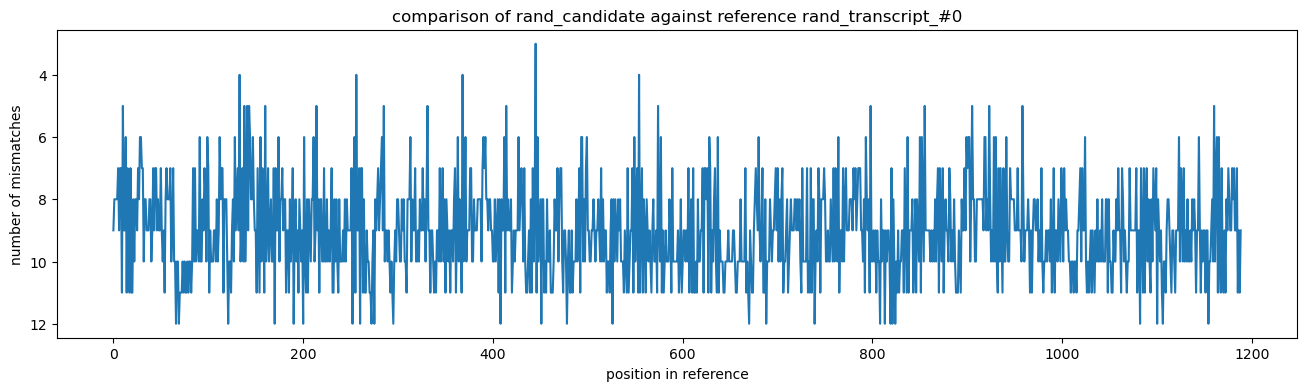

In [4]:
mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode(), ref.SEQUENCE.encode()) # mm = number of mismatches per position; encoding strings into bytes is faster for some reason

sc_results = {}                                              # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()                  # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()                  # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()                  # number of matches with 2 mistmatches
sc_results["boltzmann factor"] = np.sum(np.exp(-2*mm))     # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
plt.figure(figsize=(16, 4))
plt.plot(mm)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel(f"position in reference")
plt.title(f"comparison of {query.SEQ_NAME} against reference {ref.SEQ_NAME}")
sc_results

<br>  

# Search for off-target binding-sites in a dataset of transcripts
= compare a query to a dataset of reference sequences

In [5]:
binding_site_len = 10  # length of the binding sites (8-12 for pumby)
plot = True
use_weights = True

In [6]:
# generate input sequences
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 1200), "WEIGHT": np.random.poisson(5)/5} for i in range(7000)])      # The references to check against, i.e. the transcriptome in this example
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",               "SEQUENCE": random_seq(size = 800),   "WEIGHT": 1})                                                # The sequence from which we want ot find the best/unique binding site

In [7]:
# generate dataset of all possible binding sequences
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k:03d}:{k+binding_site_len:03d}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len],  "WEIGHT": target_sequence.WEIGHT} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query = query_dataset.sample().iloc[0]  # pick a random binding site candidate for this test
query

SEQ_NAME    random_target_062:072
SEQUENCE               GAACGGCTTC
WEIGHT                          1
Name: 62, dtype: object

In [8]:
#-------------------------------------------------#
#              input arguments check              #
#-------------------------------------------------#


if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
    raise ValueError('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')

if type(query) == pd.Series:  pass # everything is fine
elif type(query) == str:           # convert to pandas series
    warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
    query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
elif type(query) == pd.DataFrame and len(query) == 1:
    query = query.iloc[0]
else: raise ValueError("unsupported type for 'query', use pandas.Series")

if type(reference_dataset) == pd.DataFrame: pass # everything is fine
else: raise ValueError("unsopported type for 'reference_dataset', use pandas.DataFrame")

nts = set(reference_dataset.SEQUENCE.sample(100).sum()) | set(target_sequence.SEQUENCE)
if len(nts) != 4: # check how many nucleotides are used
    warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

joined_DF = pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0)  # add the target itself to the dataset to check against

if use_weights:  # check if the input data is okay to use weighted evalutation
    if "WEIGHT" in joined_DF.columns:
        invalid = joined_DF.WEIGHT.isin([np.inf, -np.inf, np.nan])
        if invalid.any():  
            warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT. The script might not behave as intended.")
    else: 
        print("No WEIGHT column found, switching 'use_weights = False'")
        use_weights = False



In [9]:
#-------------------------------------------------#
#  Search for binding sites in reference dataset  #
#-------------------------------------------------#
 
detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome

### check type and encode if not already done (makes it run faster, dunno why)
if type(query.SEQUENCE) == str:  q_seq = query.SEQUENCE.encode()
elif type(query.SEQUENCE) == bytes: q_seq = query.SEQUENCE
else: raise ValueError(f"unsuppported type for query sequence: {type(query.SEQUENCE)}")

for i, ref in joined_DF.iterrows():                          # iterate over all reference sequences. and the target itself as control 

    ### check type and encode if not already done (makes it run faster, dunno why)
    if type(ref.SEQUENCE) == str:  r_seq = ref.SEQUENCE.encode()
    elif type(ref.SEQUENCE) == bytes: r_seq = ref.SEQUENCE
    else: raise ValueError(f"unsuppported type for query sequence: {type(ref.SEQUENCE)}")

    mm = len(q_seq)-sc_jit(q_seq, r_seq)                      # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
    sc_row = {"SEQ_NAME": ref.SEQ_NAME}                       # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
    if use_weights: sc_row |= {"WEIGHT":ref.WEIGHT}      
    sc_row["identical match"] = (mm==0).sum()                 # number of idential matches
    sc_row["1nt mismatch"]    = (mm==1).sum()                 # number of sites with 1 mismatch
    sc_row["2nt mismatch"]    = (mm==2).sum()                 # number of sites with 2 mistmatches
    sc_row["boltzmann factor"] = np.sum(np.exp(-2*mm))      # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
    
    detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

results_R = detailed_search_results.loc[~(detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME)].reset_index(drop = True) # results from the comparison with the reference dataset (sqeuences to avoid)
results_T = detailed_search_results.loc[  detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME].reset_index(drop = True)  # results from the comparison with the target sequence
if len(results_T) > 1: # there should only be one entry for the target
    raise ValueError("unexpected result, there should only be one entry")

from IPython.display import display, HTML
display(HTML(results_T.to_html()))
results_R.sort_values("boltzmann factor")

c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQ_NAME,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
0,random_target,1.0,1,0,0,1.008789


c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQ_NAME,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
2716,random_transcript_#2716,1.8,0,0,0,0.007648
2166,random_transcript_#2166,1.6,0,0,0,0.008339
1576,random_transcript_#1576,1.6,0,0,0,0.008667
3873,random_transcript_#3873,1.4,0,0,0,0.008949
2061,random_transcript_#2061,0.6,0,0,0,0.009026
...,...,...,...,...,...,...
6061,random_transcript_#6061,0.6,1,0,0,1.018555
5140,random_transcript_#5140,0.6,1,0,0,1.024414
1190,random_transcript_#1190,1.6,1,0,0,1.026367
133,random_transcript_#0133,1.4,1,0,0,1.030273


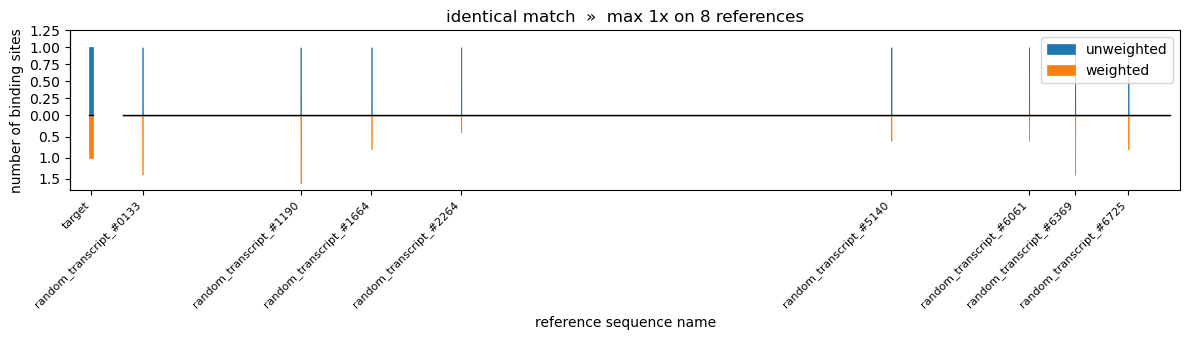

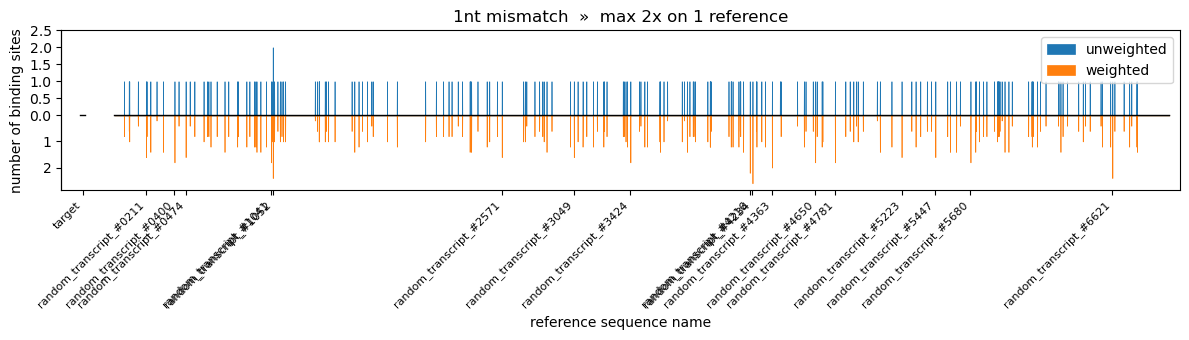

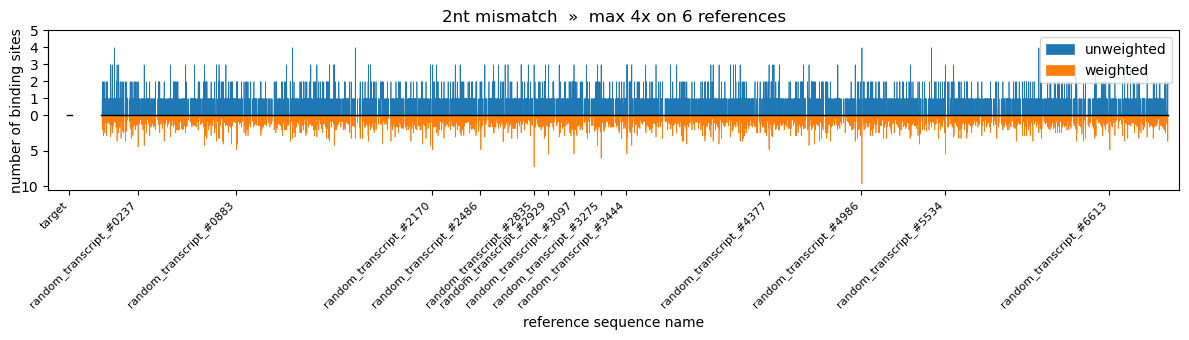

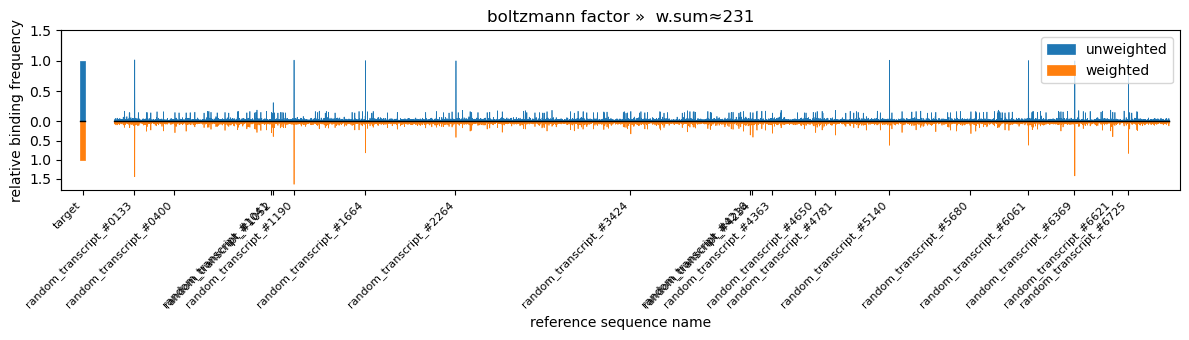

{'SEQUENCE': 'GAACGGCTTC',
 'SEQ_NAME': 'random_target_062:072',
 'identical match max': np.float64(1.0),
 'identical match sum': np.float64(8.0),
 'identical match VIR': ['random_transcript_#0133',
  'random_transcript_#1190',
  'random_transcript_#1664',
  'random_transcript_#2264',
  'random_transcript_#5140',
  'random_transcript_#6061',
  'random_transcript_#6369',
  'random_transcript_#6725'],
 'identical match W.max': np.float64(1.6),
 'identical match W.sum': np.float64(7.6000000000000005),
 'identical match W.VIR': ['random_transcript_#1190',
  'random_transcript_#0133',
  'random_transcript_#6369',
  'random_transcript_#1664',
  'random_transcript_#6725',
  'random_transcript_#6061',
  'random_transcript_#5140',
  'random_transcript_#2264'],
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(206.0),
 '1nt mismatch VIR': ['random_transcript_#1052'],
 '1nt mismatch W.max': np.float64(2.6),
 '1nt mismatch W.sum': np.float64(195.8),
 '1nt mismatch W.VIR': ['ran

In [10]:
#-------------------------------------------------------#
# summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
#-------------------------------------------------------#

# now that we have a huge and detailed list of the sequence comparison with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
query_summary = {"SEQUENCE": query.SEQUENCE, "SEQ_NAME": query.SEQ_NAME}    
for i, col in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized

    metRic = results_R[col]             # results of comparing the query i.e. candidate sequence against the Reference dataset. metrics from references -> metRic
    meTric = results_T[col][0]          # results of comparing the query i.e. candidate sequence against the Target sequence.   metrics from target   -> meTric
    if use_weights:               # weighted metric -> wetric
        wetRic =  results_R[col] * results_R["WEIGHT"]
        weTric = (results_T[col] * results_T["WEIGHT"])[0]

    if "match" in col:          # the mismatch count data is not re-normalized
        insert = ""             
        norm = 1
        norw = 1
    elif "oltzman" in col:      # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
        insert = " r2t"         # relative to target
        norm = meTric
        if use_weights: norw = weTric


    selec = ((metRic > sorted(metRic)[-min(20, len(metRic))]) | (metRic == metRic.max()) * (metRic != metRic.min())) ## (metRic > sorted(metRic)[-20]) returns the 15th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
    VIR = results_R.iloc[metRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
    query_summary[ col + f" max" + insert] = metRic.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
    query_summary[ col + f" sum" + insert] = metRic.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
    query_summary[ col + " VIR"] = VIR.tolist()

    if use_weights:
        selec = ((wetRic > sorted(wetRic)[-min(20, len(wetRic))]) | (wetRic == wetRic.max()) * (wetRic != wetRic.min())) ## (metRic > sorted(metRic)[-20]) returns the 15th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR = results_R.iloc[wetRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
        query_summary[ col + f" W.max" + insert] = wetRic.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[ col + f" W.sum" + insert] = wetRic.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        query_summary[ col + " W.VIR"] = VIR.tolist()


    #------------------------------------------------------#
    #                 Plotting the results                 #   
    #------------------------------------------------------#

    # still the same for loop iterating over every metric

    if plot:
        def round(x, digits = 3):
            mag = -int(np.floor(np.log10(x))-digits+1)
            return np.round(x, mag).astype([int, float][int(mag > 0)])
        

        sy = 1  # weighted data is shown in the same plot, but needs a seperate, rescaled y-axis. sy is this rescaling factor
        if use_weights:  
            if detailed_search_results[col].max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).min() >= 0:
                sy = detailed_search_results[col].max() / (detailed_search_results[col]*detailed_search_results.WEIGHT).max() # internal rescaling factor for the split y axis

        xmax = len(metRic)
        fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
        ax.plot([0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
        ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
        ax.fill_between(np.arange(xmax),           metRic/norm,              metRic*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
        ax.fill_between([-.032*xmax, -.028*xmax], [meTric/norm, meTric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

        if use_weights:
            ax.fill_between(np.arange(xmax),           -wetRic*sy/norw,                   wetRic*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
            ax.fill_between([-.032*xmax, -.028*xmax], [-weTric*sy/norw, -weTric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
            ax.legend(loc = "upper right")

        message = "" # for figure titles
        if "match" in col: # for the (mis) match count data
            ax.set_ylabel("number of binding sites")
            if metRic.max() > 0:  # i.e. if there are mismatches to plot.
                message = f"  »  max {metRic.max()}x on {(metRic == metRic.max()).sum()} reference{'s'*int((metRic == metRic.max()).sum() != 1)}"
        elif "oltzma" in col: # for the boltzmann factors
            if use_weights:  message =  f" »  w.sum≈{round(wetRic.sum()/norw)}"
            else:            message =  f" »  sum≈{  round(metRic.sum()/norm)}"
            ax.set_ylabel("relative binding frequency")

        ax.set_title(col + message)

        # x-axis formatting
        ax.set_xlabel("reference sequence name")
        ax.set_xticks(np.concatenate([[-0.03*xmax], VIR.index]), labels = np.concatenate([["target"], VIR.tolist()]), fontsize = 8, rotation = 45,  ha='right')
        ax.set_xlim(-0.05*xmax, 1.01*xmax)
    
        # split y axis formatting
        yt = ax.get_yticks().copy()
        ax.set_yticks(yt[yt>=0])
        sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
        plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
        yt2 = sec_y.get_yticks()
        sec_y.set_yticks(yt2[yt2>0])
        
        plt.show()

query_summary

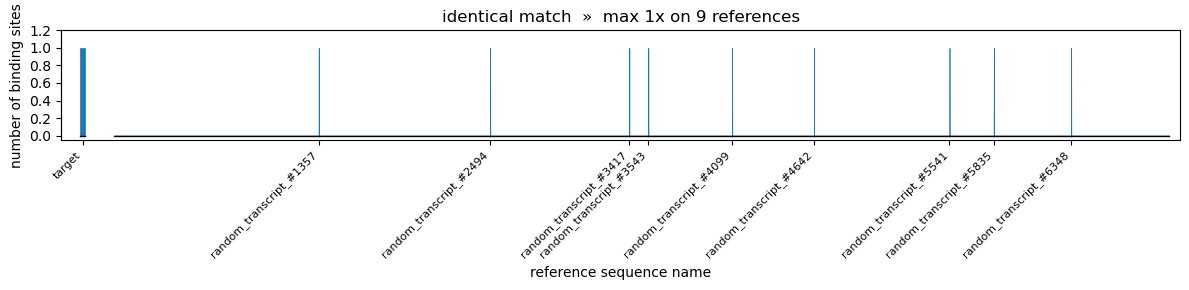

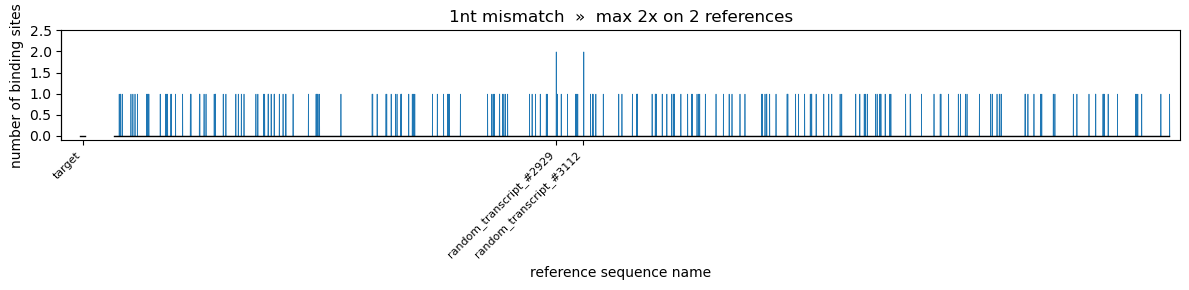

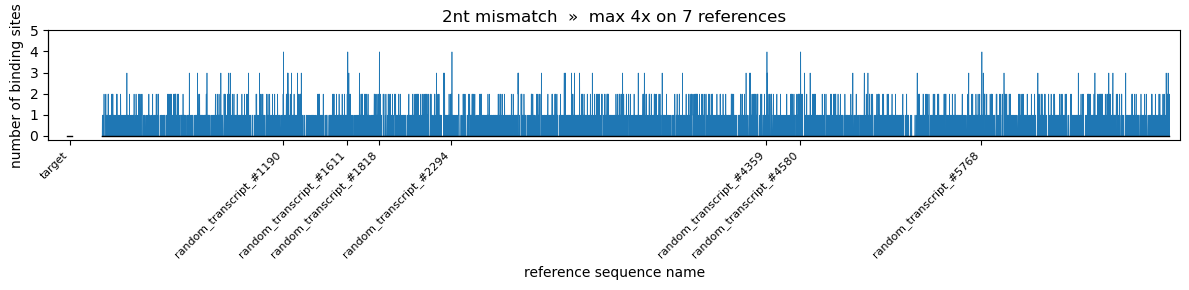

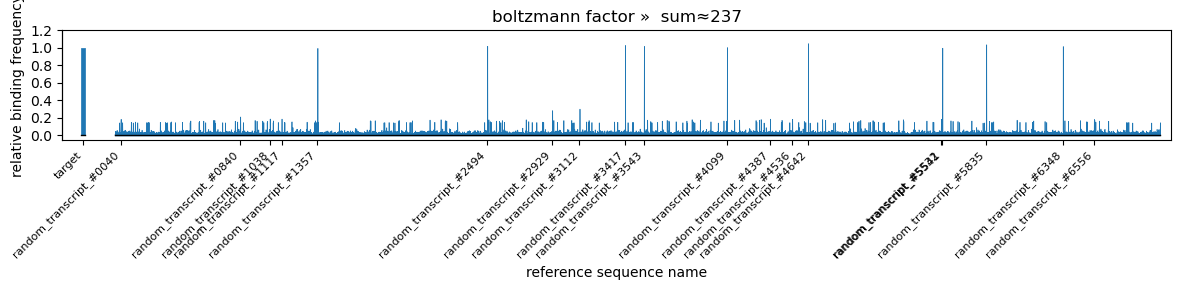

{'SEQUENCE': 513    ACTGCACTAG
 Name: SEQUENCE, dtype: object,
 'SEQ_NAME': 513    random_target_513:523
 Name: SEQ_NAME, dtype: object,
 'identical match max': np.float64(1.0),
 'identical match sum': np.float64(9.0),
 'identical match VIR': ['random_transcript_#1357',
  'random_transcript_#2494',
  'random_transcript_#3417',
  'random_transcript_#3543',
  'random_transcript_#4099',
  'random_transcript_#4642',
  'random_transcript_#5541',
  'random_transcript_#5835',
  'random_transcript_#6348'],
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(219.0),
 '1nt mismatch VIR': ['random_transcript_#2929', 'random_transcript_#3112'],
 '2nt mismatch max': np.float64(4.0),
 '2nt mismatch sum': np.float64(3274.0),
 '2nt mismatch VIR': ['random_transcript_#1190',
  'random_transcript_#1611',
  'random_transcript_#1818',
  'random_transcript_#2294',
  'random_transcript_#4359',
  'random_transcript_#4580',
  'random_transcript_#5768'],
 'boltzmann factor max r2t': np.float1

In [11]:

def round(x, digits = 3):
        mag = -int(np.floor(np.log10(x))-digits+1)
        return np.round(x, mag).astype([int, float][int(mag > 0)])


### just a copy of the cells above wrapped into  functions 

def query_eval(query, target_sequence, reference_dataset, use_weights=True):
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''
    #-------------------------------------------------#
    #              input arguments check              #
    #-------------------------------------------------#

    if not ("SEQ_NAME" in reference_dataset.columns and "SEQUENCE" in reference_dataset.columns):
        raise ValueError('reference_dataset does not contain required columns: SEQ_NAME, SEQUENCE')

    if type(query) == pd.Series:  pass # everything is fine
    elif type(query) == str:           # convert to pandas series
        warnings.warn("Warning, deprecated input type for query: string. Please use pandas.Series!")
        query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
    elif type(query) == pd.DataFrame and len(query) == 1:
        query = query.iloc[0]
    else: raise ValueError("unsupported type for 'query', use pandas.Series")

    if type(reference_dataset) == pd.DataFrame: pass # everything is fine
    else: raise ValueError("unsopported type for 'reference_dataset', use pandas.DataFrame")

    nts = set(reference_dataset.SEQUENCE.sample(100).sum()) | set(target_sequence.SEQUENCE)
    if len(nts) != 4: # check how many nucleotides are used
        warnings.warn(f"Warning, expected 4 types of nucleoties in the input, found (at least) {len(nts)}")

    joined_DF = pd.concat([pd.DataFrame([target_sequence]), reference_dataset], axis = 0)  # add the target itself to the dataset to check against

    if use_weights:  # check if the input data is okay to use weighted evalutation
        if "WEIGHT" in joined_DF.columns:
            invalid = joined_DF.WEIGHT.isin([np.inf, -np.inf, np.nan])
            if invalid.any():  
                warnings.warn(f"{invalid.sum()} entries with nan or inf WEIGHT. The script might not behave as intended.")
        else: 
            print("No WEIGHT column found, switching 'use_weights = False'")
            use_weights = False

    #-------------------------------------------------#
    #  Search for binding sites in reference dataset  #
    #-------------------------------------------------#
    
    detailed_search_results = pd.DataFrame()                     # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome

    ### check type and encode if not already done (makes it run faster, dunno why)
    if type(query.SEQUENCE) == str:  q_seq = query.SEQUENCE.encode()
    elif type(query.SEQUENCE) == bytes: q_seq = query.SEQUENCE
    else: raise ValueError(f"unsuppported type for query sequence: {type(query.SEQUENCE)}")

    for i, ref in joined_DF.iterrows():                          # iterate over all reference sequences. and the target itself as control 

        ### check type and encode if not already done (makes it run faster, dunno why)
        if type(ref.SEQUENCE) == str:  r_seq = ref.SEQUENCE.encode()
        elif type(ref.SEQUENCE) == bytes: r_seq = ref.SEQUENCE
        else: raise ValueError(f"unsuppported type for query sequence: {type(ref.SEQUENCE)}")

        mm = len(q_seq)-sc_jit(q_seq, r_seq)                      # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
        sc_row = {"SEQ_NAME": ref.SEQ_NAME}                       # summarize the possible binding sites of the query sequence against one reference sequence (here a transcript)
        if use_weights: sc_row |= {"WEIGHT":ref.WEIGHT}      
        sc_row["identical match"] = (mm==0).sum()                 # number of idential matches
        sc_row["1nt mismatch"]    = (mm==1).sum()                 # number of sites with 1 mismatch
        sc_row["2nt mismatch"]    = (mm==2).sum()                 # number of sites with 2 mistmatches
        sc_row["boltzmann factor"] = np.sum(np.exp(-2*mm))      # a very basic prediction of how likely the query sequence would bind to the reference. The wildtype pumilios have ~ 18 hydrogen bonds for 8nt i.e. 2.25 hydgrogen bonds = 2.25kT per bp, however the pumby appears to only have ~2 H-bonds per bp, and the binding statistics suggest closer to 1kT -> lets go with 1.5 for now, in the future a more accurate model might be implemented. Currently the boltzmann_factor for a perfect match is 1, if therefore this predicted boltzmann_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom 
        
        detailed_search_results = pd.concat([detailed_search_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this reference (here transcript) to the dataset

    results_R = detailed_search_results.loc[~(detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME)].reset_index(drop = True) # results from the comparison with the reference dataset (sqeuences to avoid)
    results_T = detailed_search_results.loc[  detailed_search_results.SEQ_NAME == target_sequence.SEQ_NAME].reset_index(drop = True)  # results from the comparison with the target sequence
    if len(results_T) > 1: # there should only be one entry for the target
        raise ValueError("unexpected result, there should only be one entry")

    return results_R, results_T, use_weights


def query_eval_summary(query, target_sequence, reference_dataset, plot = False, use_weights=True):
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''
    results_R, results_T, use_weights = query_eval(query, target_sequence, reference_dataset, use_weights)
    return _query_eval_summarizer(query, results_R, results_T, use_weights, plot)

def _query_eval_summarizer(query, results_R, results_T, use_weights, plot = False):
    '''internal function processing the results of query_eval'''

    #-------------------------------------------------------#
    # summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    #-------------------------------------------------------#

    # now that we have a huge and detailed list of the sequence comparison with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    query_summary = {"SEQUENCE": query.SEQUENCE, "SEQ_NAME": query.SEQ_NAME}    
    for i, col in enumerate(["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]): # iterate over all the metrics that should be summarized

        metRic = results_R[col]             # results of comparing the query i.e. candidate sequence against the Reference dataset. metrics from references -> metRic
        meTric = results_T[col][0]          # results of comparing the query i.e. candidate sequence against the Target sequence.   metrics from target   -> meTric
        if use_weights:               # weighted metric -> wetric
            wetRic =  results_R[col] * results_R["WEIGHT"]
            weTric = (results_T[col] * results_T["WEIGHT"])[0]

        if "match" in col:          # the mismatch count data is not re-normalized
            insert = ""             
            norm = 1
            norw = 1
        elif "oltzman" in col:      # for the Boltzmann factor it is compared to the Boltzmann factor of the query sequence --> relative comparison of query binding to the target vs transcripts
            insert = " r2t"         # relative to target
            norm = meTric
            if use_weights: norw = weTric


        selec = ((metRic > sorted(metRic)[-min(20, len(metRic))]) | (metRic == metRic.max()) * (metRic != metRic.min())) ## (metRic > sorted(metRic)[-20]) returns the 15th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
        VIR = results_R.iloc[metRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
        query_summary[ col + f" max" + insert] = metRic.max() / norm        # What was the highest number of off-target binding sites on a single reference i.e. transcript
        query_summary[ col + f" sum" + insert] = metRic.sum() / norm        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
        query_summary[ col + " VIR"] = VIR.tolist()

        if use_weights:
            selec = ((wetRic > sorted(wetRic)[-min(20, len(wetRic))]) | (wetRic == wetRic.max()) * (wetRic != wetRic.min())) ## (metRic > sorted(metRic)[-20]) returns the 15th largest value, also ever value equal to the largest one is included. Overrulling everything else is the exclusion of the min value
            VIR = results_R.iloc[wetRic[selec].sort_values(ascending = False).index].SEQ_NAME  # Very Important References ; 
            query_summary[ col + f" W.max" + insert] = wetRic.max() / norw        # What was the highest number of off-target binding sites on a single reference i.e. transcript
            query_summary[ col + f" W.sum" + insert] = wetRic.sum() / norw        # What was the  total  number of off-target binding sites on the whole reference dataset i.e. transcriptome
            query_summary[ col + " W.VIR"] = VIR.tolist()


        #------------------------------------------------------#
        #                 Plotting the results                 #   
        #------------------------------------------------------#

        # still the same for loop iterating over every metric

        if plot:
            def round(x, digits = 3):
                mag = -int(np.floor(np.log10(x))-digits+1)
                return np.round(x, mag).astype([int, float][int(mag > 0)])
            

            sy = 1  # weighted data is shown in the same plot, but needs a seperate, rescaled y-axis. sy is this rescaling factor
            if use_weights:  
                if detailed_search_results[col].max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).max() != 0 and (detailed_search_results[col]*detailed_search_results.WEIGHT).min() >= 0:
                    sy = detailed_search_results[col].max() / (detailed_search_results[col]*detailed_search_results.WEIGHT).max() # internal rescaling factor for the split y axis

            xmax = len(metRic)
            fig, ax = plt.subplots(1, 1, figsize = (12, 3 + .5*int(use_weights)))
            ax.plot([0, xmax],                [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for references
            ax.plot([-.032*xmax, -.028*xmax], [0, 0], zorder = 10, color = "black", lw = 1) # plot black zero line for target
            ax.fill_between(np.arange(xmax),           metRic/norm,              metRic*0, color = "tab:blue", ec = "tab:blue", lw = .5, label = "unweighted")    # plot unweighted results of references
            ax.fill_between([-.032*xmax, -.028*xmax], [meTric/norm, meTric/norm], [0,0],   color = "tab:blue", ec = "tab:blue", lw = .5)                          # plot unweighted results of target

            if use_weights:
                ax.fill_between(np.arange(xmax),           -wetRic*sy/norw,                   wetRic*0,  color = "tab:orange", ec = "tab:orange", lw = .5, label = "weighted")           # plot weighted results of references
                ax.fill_between([-.032*xmax, -.028*xmax], [-weTric*sy/norw, -weTric*sy/norw], [0,0],     color = "tab:orange", ec = "tab:orange", lw = .5)                               # plot weighted results of target
                ax.legend(loc = "upper right")

            message = "" # for figure titles
            if "match" in col: # for the (mis) match count data
                ax.set_ylabel("number of binding sites")
                if metRic.max() > 0:  # i.e. if there are mismatches to plot.
                    message = f"  »  max {metRic.max()}x on {(metRic == metRic.max()).sum()} reference{'s'*int((metRic == metRic.max()).sum() != 1)}"
            elif "oltzma" in col: # for the boltzmann factors
                if use_weights:  message =  f" »  w.sum≈{round(wetRic.sum()/norw)}"
                else:            message =  f" »  sum≈{  round(metRic.sum()/norm)}"
                ax.set_ylabel("relative binding frequency")

            ax.set_title(col + message)

            # x-axis formatting
            ax.set_xlabel("reference sequence name")
            ax.set_xticks(np.concatenate([[-0.03*xmax], VIR.index]), labels = np.concatenate([["target"], VIR.tolist()]), fontsize = 8, rotation = 45,  ha='right')
            ax.set_xlim(-0.05*xmax, 1.01*xmax)
        
            # split y axis formatting
            yt = ax.get_yticks().copy()
            ax.set_yticks(yt[yt>=0])
            sec_y = ax.secondary_yaxis("left", functions = (lambda y: -y/sy, lambda y: -y*sy))
            plt.tight_layout() # need to be called before getting ytick values as this triggers matplotlib to calculate the layout and the ticks correctly.
            yt2 = sec_y.get_yticks()
            sec_y.set_yticks(yt2[yt2>0])
            
            plt.show()

    return query_summary

query_eval_summary(query_dataset.sample(), target_sequence, reference_dataset, True, False)

In [12]:
%timeit query_eval_summary(query_dataset.sample(), target_sequence, reference_dataset, plot = False, use_weights = True)
%timeit query_eval_summary(query_dataset.sample(), target_sequence, reference_dataset, plot = False, use_weights = False)

3.18 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.93 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



# Now query all possible candidate sequences from the target (in parallel)


In [13]:
binding_site_len = 12  # length of the binding sites (8-12 for pumby)
plot = False
save_path = ".temp"

# generate input sequences
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i:04d}", "SEQUENCE": random_seq(size = 1200),                   "WEIGHT": np.random.poisson(5)/5} for i in range(7000)])  # The reference to check against, i.e. a transcript from the transcriptome in this example
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",               "SEQUENCE": random_seq(size = 800+binding_site_len),   "WEIGHT": 1})                                             # The sequence from which we want ot find the best/unique binding site

# retrieve all possible binding sites of the target sequence
query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k:03d}:{k+binding_site_len:03d}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len]} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query_dataset  

,SEQ_NAME,SEQUENCE
0,random_target_000:012,TCTCCATTTACT
1,random_target_001:013,CTCCATTTACTA
2,random_target_002:014,TCCATTTACTAA
3,random_target_003:015,CCATTTACTAAA
4,random_target_004:016,CATTTACTAAAG
...,...,...
795,random_target_795:807,CGATACTGGTGT
796,random_target_796:808,GATACTGGTGTC
797,random_target_797:809,ATACTGGTGTCA
798,random_target_798:810,TACTGGTGTCAG


In [14]:
#-------------------------------#
#  Parallel processing: joblib  #  
#-------------------------------#          # using joblib instead of multiprocessing becasue of windows compatibility
from joblib import Parallel, delayed
from tqdm import tqdm
import pathlib

pathlib.Path(save_path).mkdir(parents=True, exist_ok=True) 
scores = pd.DataFrame(list(Parallel(n_jobs=-1)(delayed(query_eval_summary)(query, target_sequence, reference_dataset) for row_ID, query in tqdm(query_dataset.iterrows(), total=len(query_dataset), ncols = 100))))
scores.to_csv(pathlib.Path(save_path).joinpath(f"{target_sequence.SEQ_NAME}.csv"), index = False)

100%|█████████████████████████████████████████████████████████████| 800/800 [03:22<00:00,  3.95it/s]


<br>
<br>
<br>
<br>

In [15]:
scores

c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQUENCE,SEQ_NAME,identical match max,identical match sum,identical match VIR,identical match W.max,identical match W.sum,identical match W.VIR,1nt mismatch max,1nt mismatch sum,...,2nt mismatch VIR,2nt mismatch W.max,2nt mismatch W.sum,2nt mismatch W.VIR,boltzmann factor max r2t,boltzmann factor sum r2t,boltzmann factor VIR,boltzmann factor W.max r2t,boltzmann factor W.sum r2t,boltzmann factor W.VIR
0,TCTCCATTTACT,random_target_000:012,0.0,0.0,[],0.0,0.0,[],2.0,18.0,...,"[random_transcript_#0101, random_transcript_#0...",4.0,305.6,"[random_transcript_#5808, random_transcript_#5...",0.272949,28.906250,"[random_transcript_#2086, random_transcript_#1...",0.382098,29.328342,"[random_transcript_#2086, random_transcript_#3..."
1,CTCCATTTACTA,random_target_001:013,0.0,0.0,[],0.0,0.0,[],1.0,15.0,...,"[random_transcript_#0697, random_transcript_#1...",2.8,304.4,"[random_transcript_#2086, random_transcript_#2...",0.160400,28.812500,"[random_transcript_#5375, random_transcript_#0...",0.308805,29.231213,"[random_transcript_#3834, random_transcript_#5..."
2,TCCATTTACTAA,random_target_002:014,0.0,0.0,[],0.0,0.0,[],1.0,19.0,...,"[random_transcript_#0026, random_transcript_#1...",4.4,293.8,"[random_transcript_#1345, random_transcript_#2...",0.141357,28.890625,"[random_transcript_#3095, random_transcript_#2...",0.197856,28.669032,"[random_transcript_#3095, random_transcript_#3..."
3,CCATTTACTAAA,random_target_003:015,0.0,0.0,[],0.0,0.0,[],2.0,24.0,...,"[random_transcript_#1130, random_transcript_#2...",3.2,286.6,"[random_transcript_#1130, random_transcript_#3...",0.270996,29.734375,"[random_transcript_#1345, random_transcript_#3...",0.596456,29.836664,"[random_transcript_#1345, random_transcript_#2..."
4,CATTTACTAAAG,random_target_004:016,0.0,0.0,[],0.0,0.0,[],1.0,25.0,...,"[random_transcript_#0597, random_transcript_#1...",3.2,283.8,"[random_transcript_#5453, random_transcript_#4...",0.173706,29.750000,"[random_transcript_#4848, random_transcript_#1...",0.340540,29.832294,"[random_transcript_#1345, random_transcript_#4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,CGATACTGGTGT,random_target_795:807,0.0,0.0,[],0.0,0.0,[],1.0,22.0,...,"[random_transcript_#0506, random_transcript_#3...",2.8,289.0,"[random_transcript_#6786, random_transcript_#4...",0.140625,29.296875,"[random_transcript_#3538, random_transcript_#6...",0.252000,29.212681,"[random_transcript_#4324, random_transcript_#5..."
796,GATACTGGTGTC,random_target_796:808,0.0,0.0,[],0.0,0.0,[],1.0,18.0,...,"[random_transcript_#2564, random_transcript_#3...",3.6,304.2,"[random_transcript_#2564, random_transcript_#6...",0.154785,29.250000,"[random_transcript_#0484, random_transcript_#4...",0.202829,29.372679,"[random_transcript_#4521, random_transcript_#6..."
797,ATACTGGTGTCA,random_target_797:809,1.0,1.0,[random_transcript_#4521],1.4,1.4,[random_transcript_#4521],1.0,19.0,...,"[random_transcript_#0484, random_transcript_#0...",3.6,317.8,"[random_transcript_#2564, random_transcript_#6...",1.000977,30.671875,"[random_transcript_#4521, random_transcript_#6...",1.401365,31.260505,"[random_transcript_#4521, random_transcript_#6..."
798,TACTGGTGTCAG,random_target_798:810,0.0,0.0,[],0.0,0.0,[],1.0,22.0,...,"[random_transcript_#0060, random_transcript_#3...",2.8,308.2,"[random_transcript_#6396, random_transcript_#5...",0.154663,30.062500,"[random_transcript_#6917, random_transcript_#0...",0.247368,30.020417,"[random_transcript_#6917, random_transcript_#1..."


# Visualize results

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import warnings
import pathlib



def filter_weighted(df):
    df_desc = df[["SEQUENCE", "SEQ_NAME"]]
    df_data = df.drop(["SEQUENCE", "SEQ_NAME"], axis = 1)
    df_w = df_data[[col for col in df_data.columns if "W." in col]]
    df_u = df_data[[col for col in df_data.columns if not "W." in col]]
    DFU = pd.concat([df_desc, df_u], axis = 1) # unweighted results
    DFW = pd.concat([df_desc, df_w], axis = 1) # weighted results
    return DFW

def filter_unweighted(df):
    df_desc = df[["SEQUENCE", "SEQ_NAME"]]
    df_data = df.drop(["SEQUENCE", "SEQ_NAME"], axis = 1)
    df_w = df_data[[col for col in df_data.columns if "W." in col]]
    df_u = df_data[[col for col in df_data.columns if not "W." in col]]
    DFU = pd.concat([df_desc, df_u], axis = 1) # unweighted results
    DFW = pd.concat([df_desc, df_w], axis = 1) # weighted results
    return DFU

def fuzzy_divisors(n, f):
    divisors = []
    for i in range(1, n + 1):
        if n % i < f:
            divisors.append(i)
    return divisors


def show_PCA(df, cols = None):
    '''plots results of all queries in a PCA scatterplot'''
    df = df.copy()
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    data = StandardScaler().fit_transform(df.select_dtypes(np.number))
    PCA1, PCA2 = PCA(n_components=2).fit_transform(data).T
    dfn = df.select_dtypes(np.number)

    if type(cols) == type(None):
        columns = dfn.columns
    else:
        columns = cols

    n = len(columns)
    if n == 1:
        nrow = 1
        ncol = 1

    else:
        for f in range(100):
            ds = np.array(fuzzy_divisors(n, f))
            candidates = ds[(ds>0.4*n**0.5)*(ds<=0.8*n**0.5)]
            if len(candidates) > 0:
                nrow = candidates[np.argmin(np.abs(np.log((candidates / (0.4*n**0.5)))))]
                ncol = np.ceil(n/nrow).astype(int);
                break;

    fig, axes = plt.subplots(nrow, ncol, figsize = (2.5*ncol, 2*nrow))
    for col, ax in zip(columns, np.array([axes]).flatten()):
        points = ax.scatter(PCA1, PCA2, c = dfn[col], s = 5, alpha = 1)
        ax.set_title(col)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.colorbar(points, ax = ax)
    plt.tight_layout()
    plt.show()

def show_map(df):
    '''Visualize the number of offtarget binding sites and boltzmann factors of all queries from the target sequence'''
    df = df.copy()
    for col in ["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]:
        _cols = df.columns[np.array([col in _c for _c in df.columns])]
        col1 = _cols[["sum" in _c for _c in _cols]][0]
        col2 = _cols[["max" in _c for _c in _cols]][0]
        print(col1)
        _min = 0
        if "W." in col1: _min = 0
        sel = df[df[col2]==_min]
        
        plt.figure(figsize = (20, 3))
        sy = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int) # rescaling for the lower half of the plot, only visual
        plt.bar(df.index,  df[col1].values, label = "total sum in transcriptome", width = 1, color = "tab:cyan")
        plt.bar(df.index, -df[col2].values*sy,  label = "max per transcript", width = 1, color = "tab:purple")
        if len(sel) > 0 and df[col2].min() == 0:
            plt.bar(sel.index, .04*df[col1].max(), bottom = -.02*df[col2].max()*sy, label = f"no {col} off-target binding sites in any transcript", color = "black", width = 1)
        plt.xlabel("target candidates")
        yl = plt.yticks()[0]
        yl[yl<0] /= sy
        yl = np.unique(yl.round().astype(int))
        yt = yl.copy()
        yt[yt<0] *= sy
        plt.yticks(yt, np.abs(yl))
        plt.legend();

        if not  "oltzman" in col:
            plt.ylabel(f"number of {col} \n off-target binding sites");

            if len(sel) == 0:
                plt.title(f"no candidate without {col} off-target binding sites found")
            elif df[col2].min() == 0:
                plt.title(f"{len(sel)} candidates without {col} off-target binding sites found")
            else:
                plt.title(f"{len(sel)} candidates with max {round(df[col2].min())}x {col} off-target binding sites found")
        else: 
            plt.title("relative boltzmann factors normalised to BF of target sequence")
            plt.ylabel(f"{col} of \n off-target binding sites");


        plt.show()
        
def col_weight(col):
    col_name = col.name
    if "W." in col_name: m = 2
    else: m = 1
    if "identical" in col_name or "boltzman" in col_name:    return m*1
    elif "1nt" in col_name:                                  return m*1/2
    elif "2nt" in col_name:                                  return m*1/4
    else:                                                    return m*1/8


def show_df(df, all):

    cmi = []
    for col in df.columns:
        main = col
        suffix = ""
        for _main in ["identical match ", "1nt mismatch ", "2nt mismatch ", "1nt mismatch ", "boltzmann factor ", "rank "]:
            frag = col.split(_main)
            if len(frag) == 2:
                suffix = frag[1]
                main = _main
                break;
        cmi.append((main, suffix))

    _df = pd.concat([df, pd.DataFrame([all.select_dtypes("number").median()], index = [None])], axis = 0, join = "outer")
    _df.columns = pd.MultiIndex.from_tuples(cmi)


    def nice_format(var, digits = 3):

        try:
            x = float(var)
            if var == 0: return int(0)
            if np.isnan(var): return "---"
            mag = -int(np.floor(np.log10(x))-digits+1)
            num = np.round(x, mag)
            if mag > 0:
                if int(var) == var: return int(var)
                return (f"{num:.{mag}f}")
            else: 
                return (f"{int(num)}")    
        except: return var

    header0  = {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'}
    header1  = {'selector': 'th.col_heading.level1', 'props': 'border-bottom: 5px solid white'}
    footer  = {'selector': '.data', 'props': 'border-top: 2px solid white'}
    general = {'selector': 'th, td',                     'props': 'text-align: center;'}
    _df = _df.sort_index().reset_index(names = ["position"])
    _s = _df.style.background_gradient(axis=0, cmap = "Spectral", subset=["position"]).hide(axis='index')

    for col in _df.drop(("position", ""), axis = 1).select_dtypes("number").columns:
        _s = _s.background_gradient(axis=0, cmap = "coolwarm", subset = [col], vmax = all[col[0] + col[1]].median()*2 - all[col[0] + col[1]].min(), vmin = 1*all[col[0] + col[1]].min())
    _s = _s.hide([col for col in _df.columns if np.any([pattern in col[1] for pattern in ["VIR"]]) or np.any([pattern in col[0] for pattern in ["bin", "selected"]])], axis = 1,).set_table_styles([header0, header1, general, footer])
    _s = _s.format(nice_format).format((lambda x: f"{x:.0f}" if not np.isnan(x) else "all.median"), subset = ["position"])
    _s = _s.set_table_styles({head: [{'selector': 'th, td', 'props': 'border-left: 5px solid white'}] for head in _df.columns if (head[1].startswith("max")) or (head[1] == "")}, overwrite=False, axis=0)
    _s = _s.set_table_styles({("position", ""):[{'selector': 'td', 'props': "font-weight: bold"}]},  overwrite=False, axis=0)
    _s = _s.set_table_styles({("SEQUENCE", ""):[{'selector': 'td', 'props': "font-family: monospace"}]},  overwrite=False, axis=0)
    return _s


identical match sum


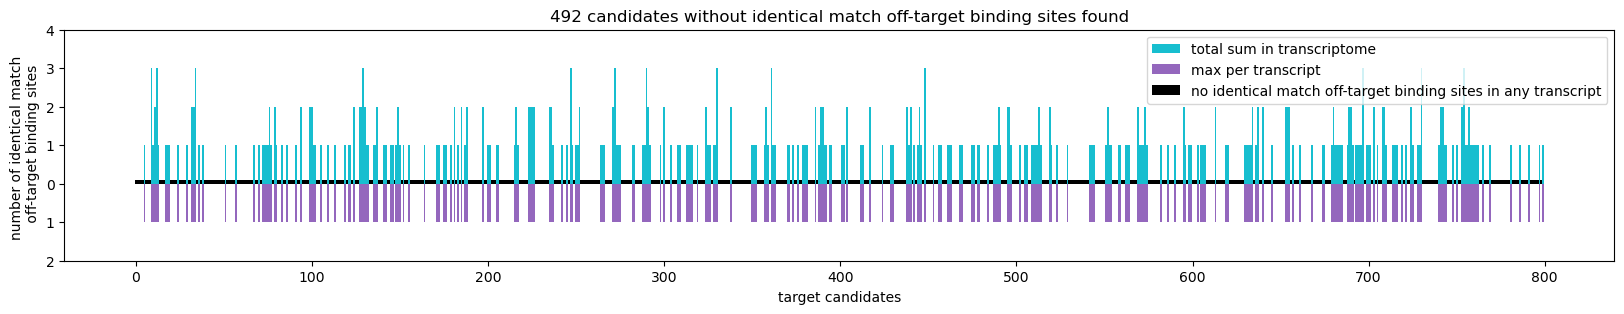

1nt mismatch sum


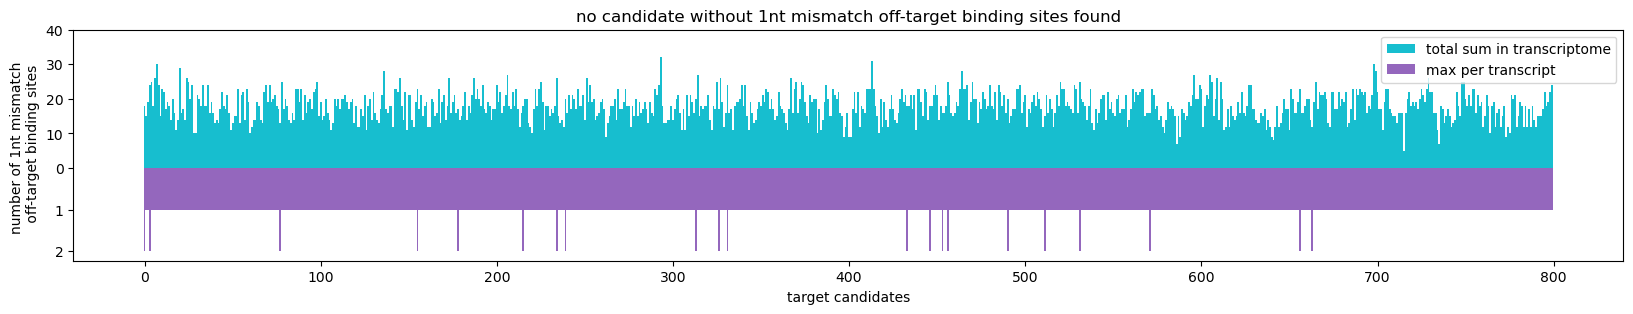

2nt mismatch sum


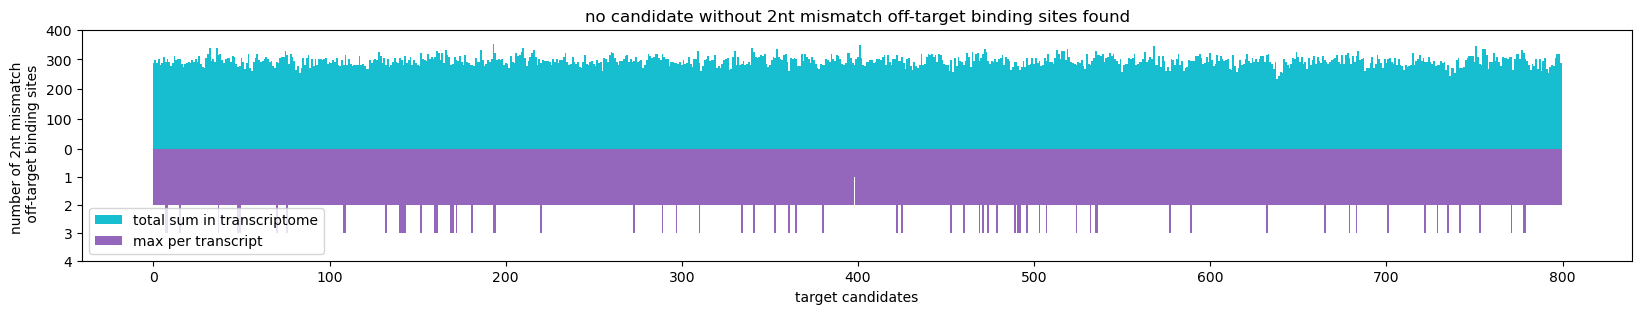

boltzmann factor sum r2t


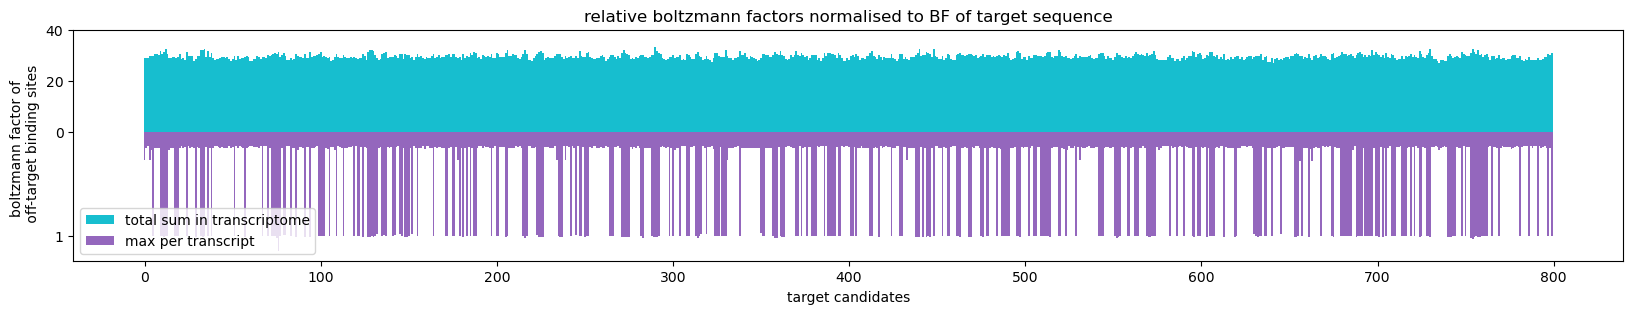

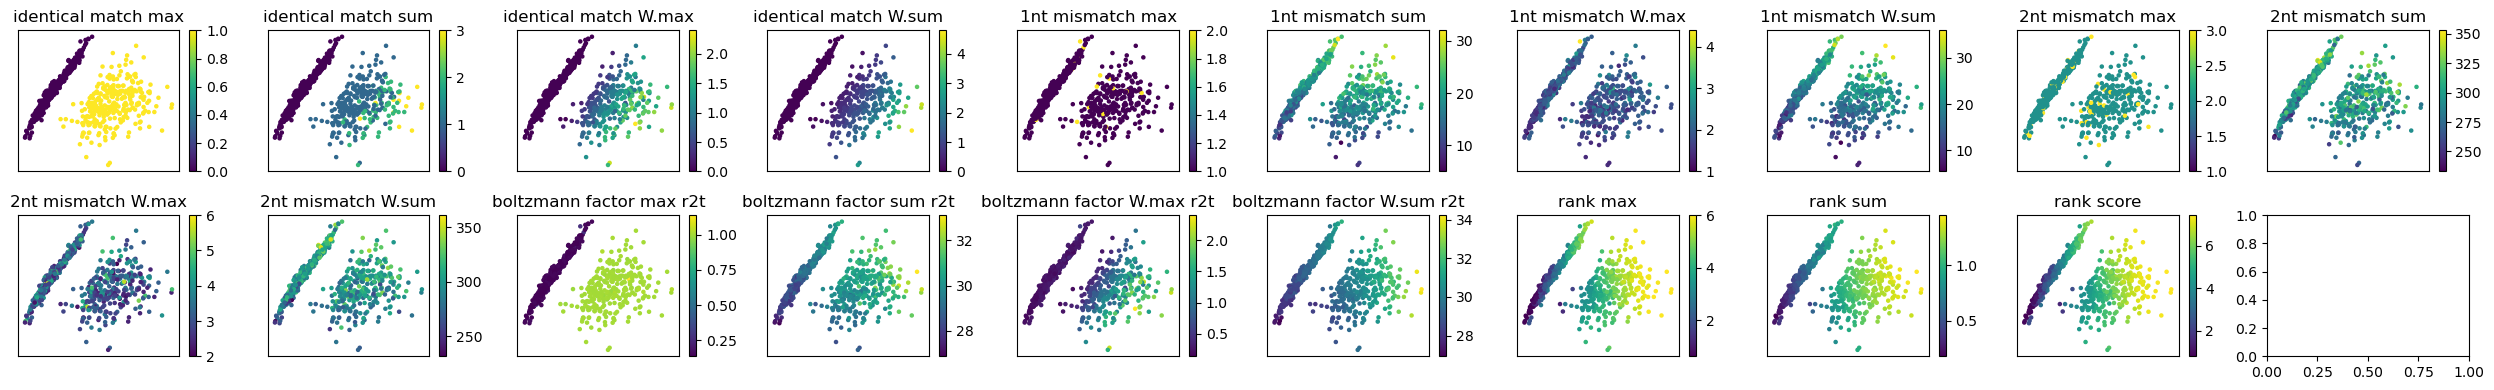

,SEQUENCE,SEQ_NAME,identical match max,identical match sum,identical match VIR,identical match W.max,identical match W.sum,identical match W.VIR,1nt mismatch max,1nt mismatch sum,...,2nt mismatch W.VIR,boltzmann factor max r2t,boltzmann factor sum r2t,boltzmann factor VIR,boltzmann factor W.max r2t,boltzmann factor W.sum r2t,boltzmann factor W.VIR,rank max,rank sum,rank score
0,TCTCCATTTACT,random_target_000:012,0.0,0.0,[],0.0,0.0,[],2.0,18.0,...,"[random_transcript_#5808, random_transcript_#5...",0.2730,28.90,"[random_transcript_#2086, random_transcript_#1...",0.382098,29.328342,"[random_transcript_#2086, random_transcript_#3...",3.1675,0.789561,3.957061
1,CTCCATTTACTA,random_target_001:013,0.0,0.0,[],0.0,0.0,[],1.0,15.0,...,"[random_transcript_#2086, random_transcript_#2...",0.1604,28.81,"[random_transcript_#5375, random_transcript_#0...",0.308805,29.231213,"[random_transcript_#3834, random_transcript_#5...",2.7750,0.680098,3.455098
2,TCCATTTACTAA,random_target_002:014,0.0,0.0,[],0.0,0.0,[],1.0,19.0,...,"[random_transcript_#1345, random_transcript_#2...",0.1414,28.89,"[random_transcript_#3095, random_transcript_#2...",0.197856,28.669032,"[random_transcript_#3095, random_transcript_#3...",1.0575,0.375479,1.432979
3,CCATTTACTAAA,random_target_003:015,0.0,0.0,[],0.0,0.0,[],2.0,24.0,...,"[random_transcript_#1130, random_transcript_#3...",0.2710,29.73,"[random_transcript_#1345, random_transcript_#3...",0.596456,29.836664,"[random_transcript_#1345, random_transcript_#2...",3.6825,0.932412,4.614912
4,CATTTACTAAAG,random_target_004:016,0.0,0.0,[],0.0,0.0,[],1.0,25.0,...,"[random_transcript_#5453, random_transcript_#4...",0.1737,29.75,"[random_transcript_#4848, random_transcript_#1...",0.340540,29.832294,"[random_transcript_#1345, random_transcript_#4...",3.6525,0.873506,4.526006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,CGATACTGGTGT,random_target_795:807,0.0,0.0,[],0.0,0.0,[],1.0,22.0,...,"[random_transcript_#6786, random_transcript_#4...",0.1406,29.30,"[random_transcript_#3538, random_transcript_#6...",0.252000,29.212681,"[random_transcript_#4324, random_transcript_#5...",2.1450,0.555332,2.700332
796,GATACTGGTGTC,random_target_796:808,0.0,0.0,[],0.0,0.0,[],1.0,18.0,...,"[random_transcript_#2564, random_transcript_#6...",0.1548,29.25,"[random_transcript_#0484, random_transcript_#4...",0.202829,29.372679,"[random_transcript_#4521, random_transcript_#6...",2.5425,0.536807,3.079307
797,ATACTGGTGTCA,random_target_797:809,1.0,1.0,[random_transcript_#4521],1.4,1.4,[random_transcript_#4521],1.0,19.0,...,"[random_transcript_#2564, random_transcript_#6...",1.0010,30.67,"[random_transcript_#4521, random_transcript_#6...",1.401365,31.260505,"[random_transcript_#4521, random_transcript_#6...",5.4600,1.317715,6.777715
798,TACTGGTGTCAG,random_target_798:810,0.0,0.0,[],0.0,0.0,[],1.0,22.0,...,"[random_transcript_#6396, random_transcript_#5...",0.1547,30.06,"[random_transcript_#6917, random_transcript_#0...",0.247368,30.020417,"[random_transcript_#6917, random_transcript_#1...",4.0950,0.759473,4.854473


In [92]:
DF = pd.read_csv(".temp/random_target.csv")
import ast
for col in [col for col in DF.columns if "VIR" in col]:
    try: DF[col] = DF[col].apply(ast.literal_eval) 
    except: pass  

weighted_rank = ((DF.select_dtypes(np.number).rank()+2*DF.select_dtypes(np.number).rank(method = "dense")) * DF.select_dtypes(np.number).apply(col_weight))
DF["rank max"] = weighted_rank.max(axis = 1) / len(DF)
DF["rank sum"] = weighted_rank.mean(axis = 1) / len(DF) 
DF["rank score"] = DF["rank max"] +  DF["rank sum"]
 

show_map(filter_unweighted(DF))
show_PCA(DF)
DF

# selection

 - select low nt mismatches first
 - select for locally for each 1/n segments of target seperatly to ensure good binding site distribution
 - filter out VIR duplicates at the end.

In [93]:
# square = 17
# root = int(np.round(square**0.5))
# best = root
# for off in [i/2 if i % 2 == 0 else -(i+1)/2 for i in np.arange(root+1)]:
#     _root = root + off
#     print(off)
#     if np.abs(_root * int(np.ceil(square/_root)) - square) < np.abs(best * int(np.ceil(square/best)) - square):
#         best = _root

C:\Users\T3D\AppData\Local\Temp\ipykernel_20604\3545786029.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selected = df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index


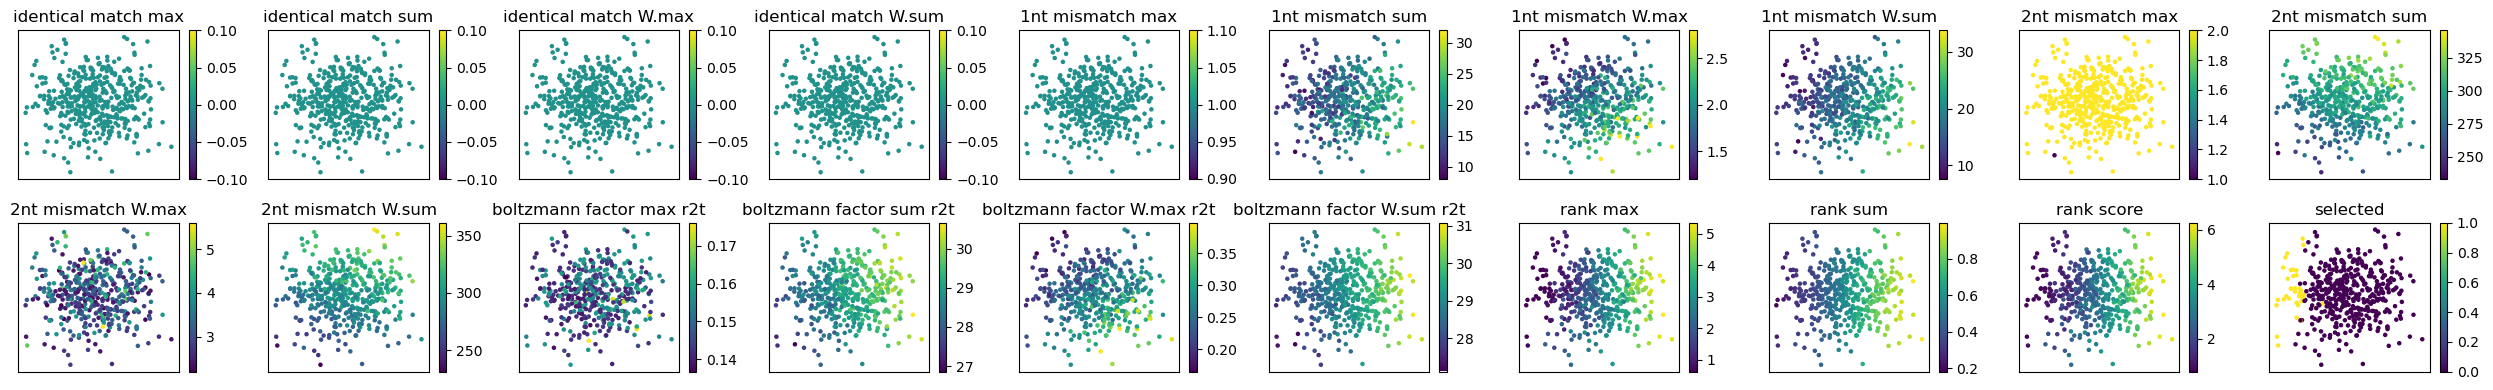

In [94]:
### Selection stage 1 ### - select evenly distributed a fixed number of samples

nbins = 6
nsmallest = 6
df = DF.copy()

max_rank = 2
min_select = nbins * nsmallest
_max = df.index.max()
for i, col in enumerate([col for col in DF.select_dtypes(np.number).columns if not "W." in col]):
    for k in range(0, max_rank+1, 1):
        sel = df[col].rank(method ='dense') <= k
        if sel.sum() >= min_select and np.histogram(df.index, bins = nbins, range = (0, _max))[0].min() > 0:
            df = df[sel]
            break

df['bin'] = pd.cut(df.index, bins=nbins)
selected = df.groupby('bin')['rank score'].nsmallest(nsmallest).reset_index(level=0, drop=True).index
df["selected"] = 0
df.loc[selected, 'selected'] = 1

show_PCA(df)

select1 = df.loc[selected]
show_df(select1, df)

In [95]:
min_select = 18
o = -1
while True:
    o += 0.001
    sel = (select1.select_dtypes('number') < (1+o)*df.select_dtypes('number').median() - o*df.select_dtypes('number').min()).sum(axis = 1 )
    if np.sum(sel == sel.max()) > min_select:
        break

sel = (select1.select_dtypes('number') < (1+o)*df.select_dtypes('number').median() - o*df.select_dtypes('number').min()).sum(axis = 1 )
select2 = select1[sel == sel.max()]
show_df(select2, df)

100%|████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 11105.84it/s]
c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQ_NAME,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
0,random_transcript_#0000,1.0,0,0,0,0.060944
1,random_transcript_#0001,1.4,0,0,1,0.068420
2,random_transcript_#0002,1.0,0,0,0,0.047119
3,random_transcript_#0003,0.8,0,0,0,0.063416
4,random_transcript_#0004,0.8,0,0,0,0.055420
...,...,...,...,...,...,...
6995,random_transcript_#6995,0.6,0,0,1,0.099426
6996,random_transcript_#6996,1.4,0,0,0,0.070312
6997,random_transcript_#6997,1.2,0,0,1,0.080444
6998,random_transcript_#6998,1.0,0,0,1,0.093933


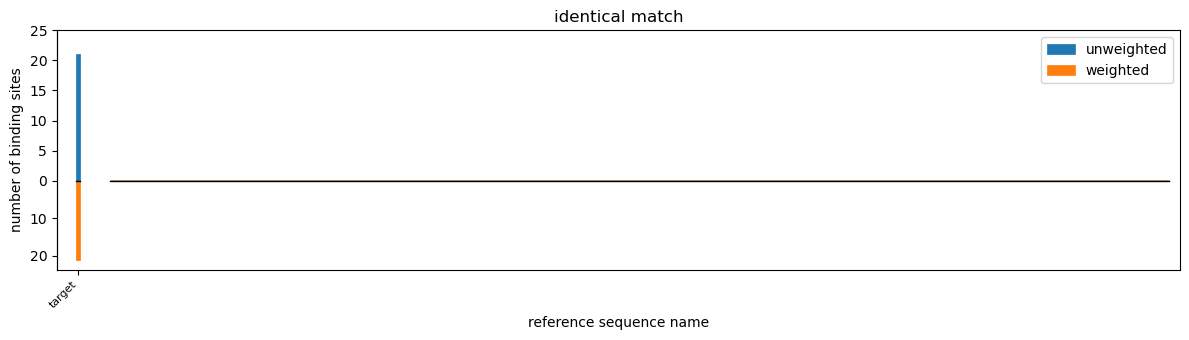

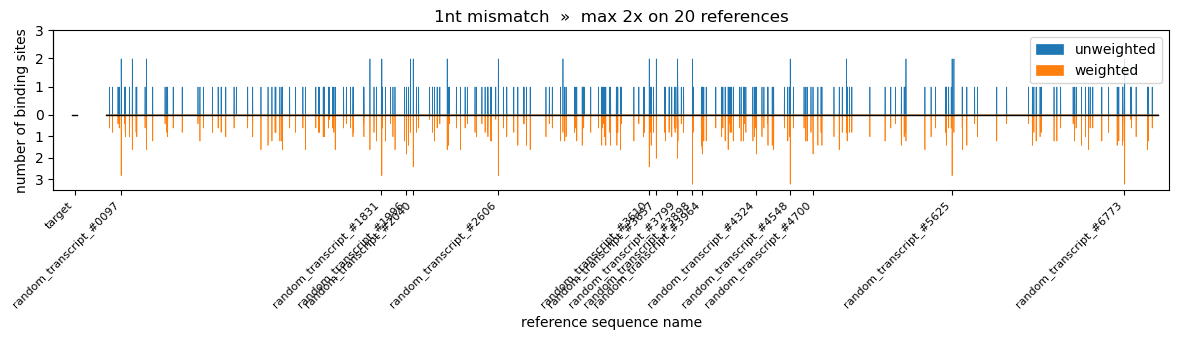

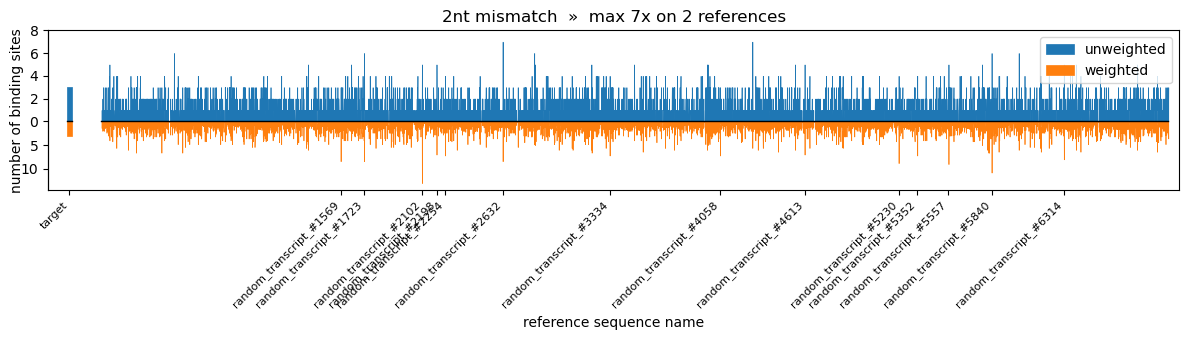

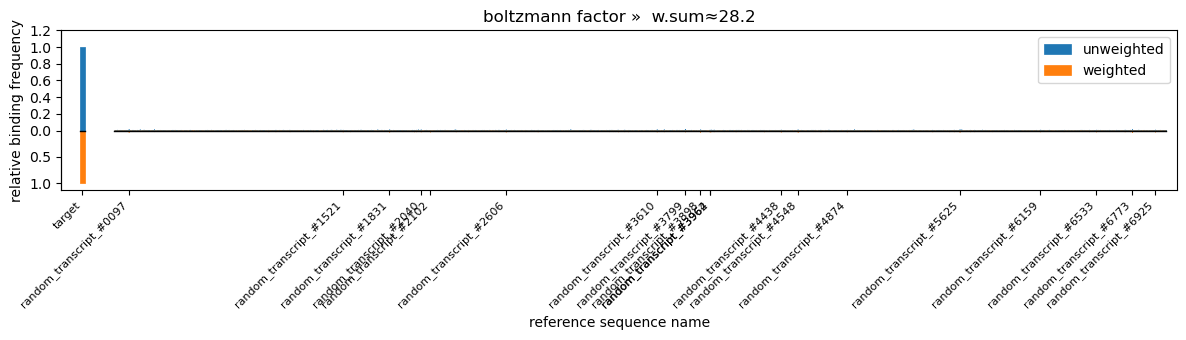

{'SEQUENCE': 'GAACGGCTTC',
 'SEQ_NAME': 'random_target_062:072',
 'identical match max': np.float64(0.0),
 'identical match sum': np.float64(0.0),
 'identical match VIR': [],
 'identical match W.max': np.float64(0.0),
 'identical match W.sum': np.float64(0.0),
 'identical match W.VIR': [],
 '1nt mismatch max': np.float64(2.0),
 '1nt mismatch sum': np.float64(295.0),
 '1nt mismatch VIR': ['random_transcript_#0097',
  'random_transcript_#0171',
  'random_transcript_#0266',
  'random_transcript_#1752',
  'random_transcript_#1831',
  'random_transcript_#2021',
  'random_transcript_#2040',
  'random_transcript_#2266',
  'random_transcript_#2606',
  'random_transcript_#3036',
  'random_transcript_#3610',
  'random_transcript_#3657',
  'random_transcript_#3799',
  'random_transcript_#3898',
  'random_transcript_#4548',
  'random_transcript_#4923',
  'random_transcript_#5318',
  'random_transcript_#5625',
  'random_transcript_#5637',
  'random_transcript_#6773'],
 '1nt mismatch W.max': np.floa

In [96]:
results = list(Parallel(n_jobs=-1)(delayed(query_eval)(query, target_sequence, reference_dataset) for row_ID, query in tqdm(select2.iterrows(), total=len(select2), ncols = 100)))
for i, result in enumerate(results):
    if i == 0: dfR, dfT, uw = result
    else: 
        dfR[["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]] += result[0][["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]]
        dfT[["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]] += result[1][["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]]

display(dfR)
_query_eval_summarizer(query, dfR, dfT, uw, plot = True)

In [97]:
### Selection stage 3 ### - avoid common off target sites 


sel = select2.drop([col for col in df.columns if ("2nt" in col) and ("VIR" in col)], axis = 1)
sel = sel[[col for col in sel.columns if not " VIR" in col]]

for col in [col for col in sel.columns if "W.VIR" in col]:
    while True:
        VIRs = sel[col].sum()
        u, c = np.unique(VIRs, return_counts= True)
        dups = u[c>1]
        if  len(dups) > 0:
            sel = sel.drop(sel[sel[col].apply(lambda ref_names: np.any([dup in ref_names for dup in dups]))]["rank score"].idxmax())
        else: break

while True:
    VIRs = sel[[col for col in sel.columns if "W.VIR" in col]].sum(axis = 1).apply(np.unique)
    u, c = np.unique(np.concat(VIRs.values), return_counts= True)
    dups = u[c>1]
    if  len(dups) > 0:
        sel = sel.drop(sel[VIRs.apply(lambda ref_names: np.any([dup in ref_names for dup in dups]))]["rank score"].idxmax())
    else: break


display(show_df(sel, df))

print(dups)

[]


100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 5879.52it/s]
c:\Users\T3D\miniforge3\envs\igem2\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQ_NAME,WEIGHT,identical match,1nt mismatch,2nt mismatch,boltzmann factor
0,random_transcript_#0000,1.0,0,0,0,0.026627
1,random_transcript_#0001,1.4,0,0,0,0.017487
2,random_transcript_#0002,1.0,0,0,0,0.015915
3,random_transcript_#0003,0.8,0,0,0,0.017929
4,random_transcript_#0004,0.8,0,0,0,0.023834
...,...,...,...,...,...,...
6995,random_transcript_#6995,0.6,0,0,0,0.020935
6996,random_transcript_#6996,1.4,0,0,0,0.028198
6997,random_transcript_#6997,1.2,0,0,0,0.025223
6998,random_transcript_#6998,1.0,0,0,0,0.031952


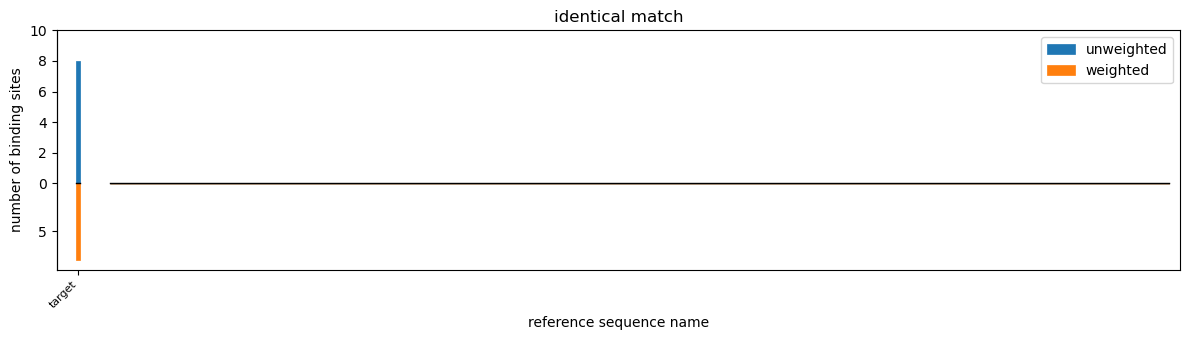

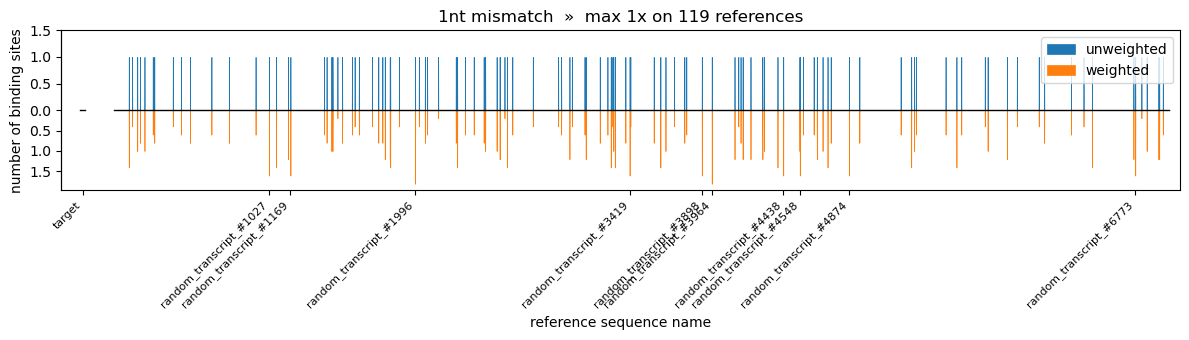

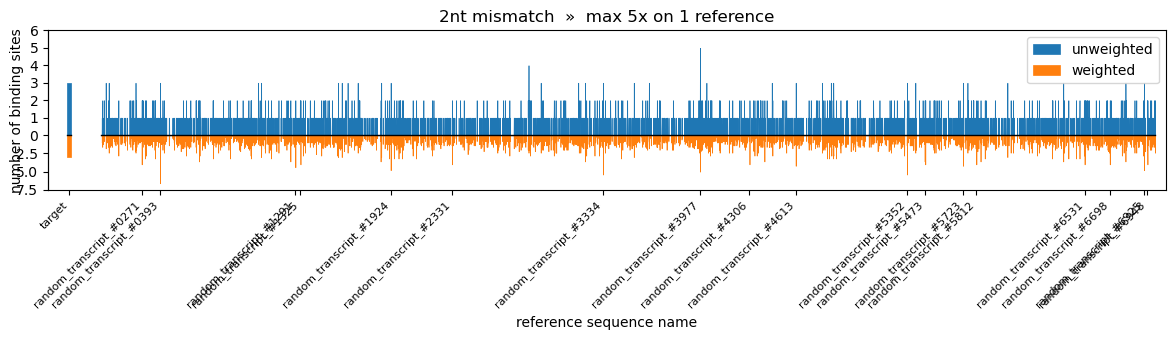

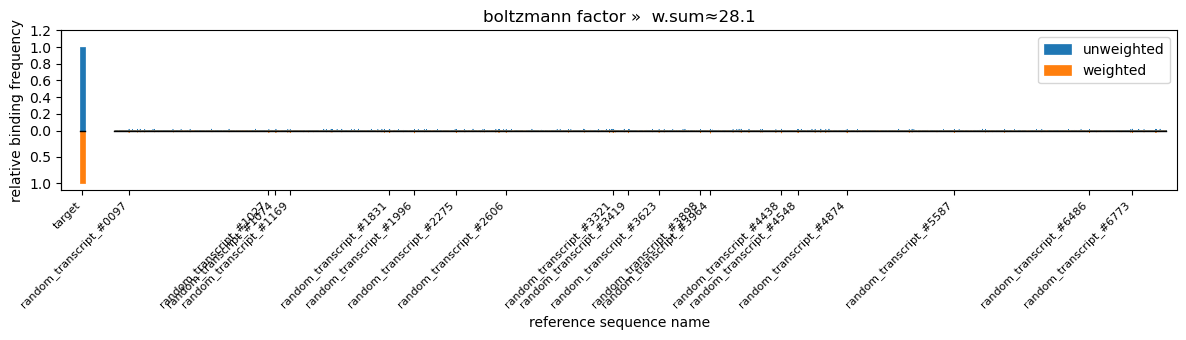

{'SEQUENCE': 'GAACGGCTTC',
 'SEQ_NAME': 'random_target_062:072',
 'identical match max': np.float64(0.0),
 'identical match sum': np.float64(0.0),
 'identical match VIR': [],
 'identical match W.max': np.float64(0.0),
 'identical match W.sum': np.float64(0.0),
 'identical match W.VIR': [],
 '1nt mismatch max': np.float64(1.0),
 '1nt mismatch sum': np.float64(119.0),
 '1nt mismatch VIR': ['random_transcript_#0097',
  'random_transcript_#0119',
  'random_transcript_#0153',
  'random_transcript_#0171',
  'random_transcript_#0201',
  'random_transcript_#0256',
  'random_transcript_#0266',
  'random_transcript_#0389',
  'random_transcript_#0443',
  'random_transcript_#0503',
  'random_transcript_#0645',
  'random_transcript_#0762',
  'random_transcript_#0938',
  'random_transcript_#1027',
  'random_transcript_#1074',
  'random_transcript_#1153',
  'random_transcript_#1169',
  'random_transcript_#1392',
  'random_transcript_#1409',
  'random_transcript_#1441',
  'random_transcript_#1446',
  

In [98]:
results = list(Parallel(n_jobs=-1)(delayed(query_eval)(query, target_sequence, reference_dataset) for row_ID, query in tqdm(sel.iterrows(), total=len(sel), ncols = 100)))
for i, result in enumerate(results):
    if i == 0: dfR, dfT, uw = result
    else: 
        dfR[["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]] += result[0][["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]]
        dfT[["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]] += result[1][["identical match", "1nt mismatch", "2nt mismatch", "boltzmann factor"]]

display(dfR)
_query_eval_summarizer(query, dfR, dfT, uw, plot = True)